# Vaccination Tweets: EDA, Sentiment Analyis

Agenda:
+ Frequency
    + most frequent words in tweets
    + look at most popular hashtags (in 'text' and in 'hashtags')
    + what is the most tweeted-about vaccine?
+ Time
    + Which vaccine "trends" in tweets? (time series)
    + Do different vaccines trend at different times as tweet subjects?

+ Sentiment
    + vaccine most closely connected to negative/positive sentiment
    + most influential sources who tweet positive/negative/neutral about vaccines in general
    + locations (uncleared) with the most positive, negative, neutral tweets
    + Positive, negative, neutral: which gets more retweets / are liked more?

(Measuring general attitude via tweets: how many people tweet by population, how many by population tweet about vaccines, how well are vaccinations monitored)

+ id:
+ user_name:
+ user_location: entered by user
+ user_description: entered by user
+ user_created: date of when the account was opened
+ user_followers: number of users which follow a specified user
+ user_friends: number of users which a specified user follows
+ user_favourites: 
+ user_verified: accounts of officially recognized organizations, users with many followers
+ date: date of tweet
+ text: text of the tweet
+ hashtags: hashtags user in the tweet
+ source: 
+ retweets: number of retweets
+ favorites:
+ is_retweet: whether the tweets is a retweet or not

Added:
+ day: 

In [265]:
# Main data packages. 
import numpy as np
import pandas as pd
from datetime import datetime

import pickle

#text processing, NLP modules
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
#plotting
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [266]:
#nltk.download('punkt')
#nltk.download('wordnet')

In [267]:
df = pd.read_csv("Data/vaccination_tweets.csv")

In [268]:
df_tweety = df.copy()

In [269]:
shape = df_tweety.shape
print('The unmodified vaccination tweets dataset contains {} columns and {} rows.'.format(shape[1], shape[0]))

The unmodified vaccination tweets dataset contains 16 columns and 38547 rows.


In [270]:
df_tweety.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38547 entries, 0 to 38546
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                38547 non-null  int64 
 1   user_name         38547 non-null  object
 2   user_location     29767 non-null  object
 3   user_description  35940 non-null  object
 4   user_created      38547 non-null  object
 5   user_followers    38547 non-null  int64 
 6   user_friends      38547 non-null  int64 
 7   user_favourites   38547 non-null  int64 
 8   user_verified     38547 non-null  bool  
 9   date              38547 non-null  object
 10  text              38547 non-null  object
 11  hashtags          30330 non-null  object
 12  source            38514 non-null  object
 13  retweets          38547 non-null  int64 
 14  favorites         38547 non-null  int64 
 15  is_retweet        38547 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 4.2+ MB


In [271]:
df_tweety.describe().round(2)

,id,user_followers,user_friends,user_favourites,retweets,favorites
count,3.854700e+04,38547.00,38547.00,38547.00,38547.00,38547.00
mean,1.365051e+18,109675.74,1309.57,15013.42,3.11,13.75
std,8.619936e+15,882398.75,6020.04,41677.98,33.87,184.20
min,1.337728e+18,0.00,0.00,0.00,0.00,0.00
25%,1.362003e+18,120.00,144.00,360.00,0.00,0.00
50%,1.366887e+18,577.00,417.00,2146.00,0.00,1.00
75%,1.371547e+18,2780.50,1189.00,11272.00,1.00,4.00
max,1.375348e+18,14906907.00,380428.00,1205878.00,2360.00,22815.00


In [272]:
df_tweety.isnull().sum()

id                     0
user_name              0
user_location       8780
user_description    2607
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            8217
source                33
retweets               0
favorites              0
is_retweet             0
dtype: int64

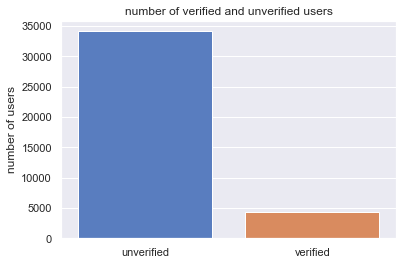

From 38547 accounts, 11.37% are verified twitter accounts.


In [273]:
sns.set_theme()
sns.set_palette('muted')
#Print users (verified/unverified), "verified" meaning that they are recognized to have some sort of official character
ax = sns.countplot(x='user_verified', data=df_tweety)
ax.set(xlabel='', ylabel='number of users', title='number of verified and unverified users')
plt.xticks(ticks=[False,True], labels=['unverified','verified'])
plt.show()
print(f'From {df_tweety.shape[0]} accounts, {round(df_tweety.user_verified.mean()*100, 2)}% are verified twitter accounts.')

In [274]:
#No tweets in this dataset appear to be retweets
df_tweety["is_retweet"].unique()

array([False])

In [275]:
#Insert column 'day' to map the vaccination progress data set
df_tweety['day'] = pd.to_datetime(df_tweety.date).dt.date

In [276]:
df_tweety.dtypes

id                   int64
user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
retweets             int64
favorites            int64
is_retweet            bool
day                 object
dtype: object

## Dropping stuff(?)

In [277]:
#'user_location' is a highly diverse category
df_tweety.user_location.nunique()

8098

In [278]:
df_tweety = df_tweety.drop(['id', 'user_created', 'is_retweet', 'source', 'user_description'], axis=1).drop_duplicates(['user_name', 'text'], keep='last').reset_index()

In [279]:
df_tweety

,index,user_name,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,retweets,favorites,day
0,0,Rachel Roh,"La Crescenta-Montrose, CA",405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],0,0,2020-12-20
1,1,Albert Fong,"San Francisco, CA",834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,1,1,2020-12-13
2,2,eli🇱🇹🇪🇺👌,Your Bed,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",0,0,2020-12-12
3,3,Charles Adler,"Vancouver, BC - Canada",49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,446,2129,2020-12-12
4,4,Citizen News Channel,NaN,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",0,0,2020-12-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38515,38542,Rising Bharat,Village,625,0,0,False,2021-03-18 06:22:41,The Sputnik V is under review for emergency us...,NaN,1,7,2021-03-18
38516,38543,Bright Uzbekistan,Uzbekistan,18,182,59,False,2021-03-18 06:13:08,IT IS PLANNED TO START MASS VACCINATION IN UZB...,NaN,0,0,2021-03-18
38517,38544,Sputnik V,"Moscow, Russia",223700,142,678,True,2021-03-18 06:01:50,Austrian Chancellor Sebastian Kurz: Concerning...,['SputnikV'],83,226,2021-03-18
38518,38545,Sputnik,NaN,322326,306,24,True,2021-03-18 05:30:00,Norwegian politicians calling to cut #SputnikV...,['SputnikV'],6,16,2021-03-18


In [280]:
#df_tweety = df_tweety.reset_index(drop='True')

In [281]:
df_tweety.to_csv('tweety.csv')

In [282]:
#create dataframes for subcategories
#df = df_tweety[(df_tweety["user_followers"]>=10)]# & (df_tweety["user_verified"]==True)] (df_tweety["user_followers"]>=10)

In [283]:
df_new = pd.read_csv('tweety.csv')

In [284]:
df_new

,Unnamed: 0,index,user_name,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,retweets,favorites,day
0,0,0,Rachel Roh,"La Crescenta-Montrose, CA",405,1692.0,3247.0,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],0.0,0.0,2020-12-20
1,1,1,Albert Fong,"San Francisco, CA",834,666.0,178.0,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,1.0,1.0,2020-12-13
2,2,2,eli🇱🇹🇪🇺👌,Your Bed,10,88.0,155.0,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",0.0,0.0,2020-12-12
3,3,3,Charles Adler,"Vancouver, BC - Canada",49165,3933.0,21853.0,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,446.0,2129.0,2020-12-12
4,4,4,Citizen News Channel,NaN,152,580.0,1473.0,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",0.0,0.0,2020-12-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38517,38515,38542,Rising Bharat,Village,625,0.0,0.0,False,2021-03-18 06:22:41,The Sputnik V is under review for emergency us...,NaN,1.0,7.0,2021-03-18
38518,38516,38543,Bright Uzbekistan,Uzbekistan,18,182.0,59.0,False,2021-03-18 06:13:08,IT IS PLANNED TO START MASS VACCINATION IN UZB...,NaN,0.0,0.0,2021-03-18
38519,38517,38544,Sputnik V,"Moscow, Russia",223700,142.0,678.0,True,2021-03-18 06:01:50,Austrian Chancellor Sebastian Kurz: Concerning...,['SputnikV'],83.0,226.0,2021-03-18
38520,38518,38545,Sputnik,NaN,322326,306.0,24.0,True,2021-03-18 05:30:00,Norwegian politicians calling to cut #SputnikV...,['SputnikV'],6.0,16.0,2021-03-18


In [285]:
# Users tweet repeptitively. About a third of users tweet repetitively. Assuming that their sentiment does not change, their sentiment is amplified.
(len(df_tweety) - df_tweety.user_name.nunique())/len(df_tweety)

0.43852544132917964

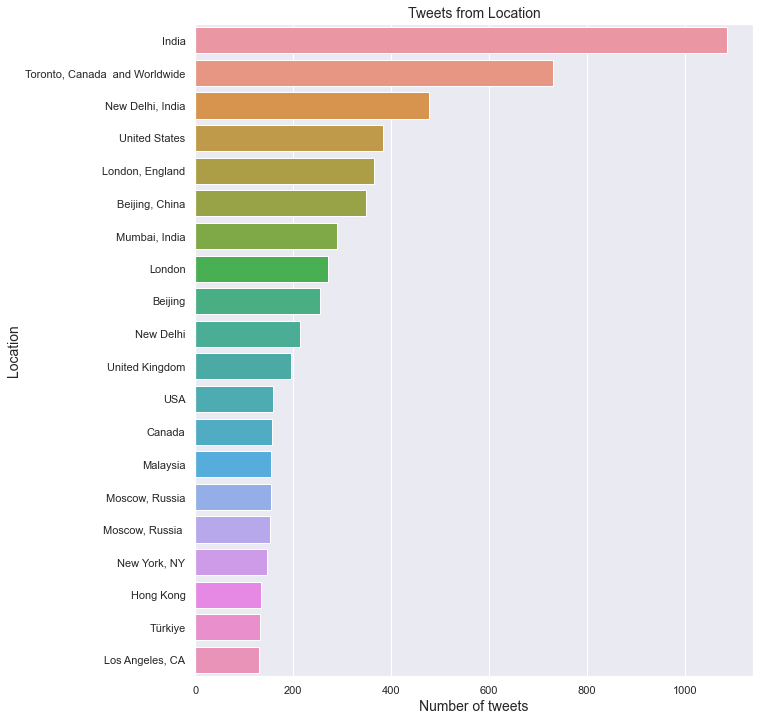

In [286]:
#user_location columns is very diverse
plt.figure(figsize=(10,12))
sns.barplot(df_tweety["user_location"].value_counts().values[0:20],
            df_tweety["user_location"].value_counts().index[0:20]);
plt.title("Tweets from Location",fontsize=14)
plt.xlabel("Number of tweets",fontsize=14)
plt.ylabel("Location",fontsize=14)
plt.show()

# Frequent words and hashtags

### Read the most popular tweets

According to # of retweets:

In [287]:
df_tweety_stat1 = df_tweety.sort_values(by='retweets', ascending=False)
print('Retweets (mean):', round(df_tweety_stat1['retweets'].mean(),2), '\n')

print('10 most responded tweets:')
df_tweety_stat1['text'].iloc[:10]

Retweets (mean): 3.11 

10 most responded tweets:


17103    Got my jab. For the curious, it was #Covaxin. ...
7117     New research published in Microbiology &amp; I...
24248    #Covaxin 🇮🇳 , made by Hyderabad-based Bharat B...
38451    A batch of fake Sputnik V vaccines was confisc...
17528    Prime Minister Narendra Modi choose early morn...
23695    This is not a queue for a Covid vaccine\nThis ...
20906    #BREAKING : Bharat Biotech says its #Covaxin s...
20516    It is tough when have to play the sauve Amrika...
13089    AIIMS nurse who gave the #Covaxin jab to Prime...
21507    The Opposition campaign to denigrate #Covaxin ...
Name: text, dtype: object

According to # of likes:

In [288]:
df_tweety_stat2 = df_tweety.sort_values(by='favorites', ascending=False)
print('Likes (mean):', round(df_tweety_stat2['favorites'].mean(),2), '\n')
print('10 most liked tweets:')
df_tweety_stat2['text'].iloc[:10]

Likes (mean): 13.76 

10 most liked tweets:


17103    Got my jab. For the curious, it was #Covaxin. ...
24248    #Covaxin 🇮🇳 , made by Hyderabad-based Bharat B...
30783    Got my #covaxin jab yesterday .. absolutely no...
17528    Prime Minister Narendra Modi choose early morn...
34974    That. Just. Happened.\n\n#Moderna #CovidVaccin...
20906    #BREAKING : Bharat Biotech says its #Covaxin s...
13089    AIIMS nurse who gave the #Covaxin jab to Prime...
20905    Phase 3 Results of #COVAXIN - announced by @Bh...
27519    I dislike shots as much as anyone. But I want ...
14309    Hon’ble PM @narendramodi We are all watching h...
Name: text, dtype: object

These two categories partly overlap.

### Most mentioned words in 'text'

In [289]:
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english') + ['i', 'the', 'get', '-', 'one']
df_tweety.text = df_tweety.text.apply(lambda x:' '.join([word for word in x.split() if word not in stopwords]))

In [290]:
tweet_words = []
for line in list(df_tweety['text']):
    words = line.split()
    for word in words:
        tweet_words.append(word.lower())
tweet_words=pd.Series(np.array(tweet_words))
frequency_ranking_words = tweet_words.value_counts()[:11].rename_axis('words_text_freq').reset_index(name='count')
#frequency_ranking_words

### Most frequent hashtags in 'text'

In [291]:
tweet_words_hasht = []
for line in df_tweety['text']:
    words = line.split()
    for word in words:
        if re.search('#[^\s]+', word):
            tweet_words_hasht.append(word)
tweet_words_hasht=pd.Series(np.array(tweet_words_hasht))
frequency_hashtags = tweet_words_hasht.value_counts()[:20].rename_axis('text_hasht_freq').reset_index(name='count')
frequency_hashtags

,text_hasht_freq,count
0,#Moderna,4978
1,#COVID19,3411
2,#Covaxin,3116
3,#PfizerBioNTech,2889
4,#SputnikV,2768
5,#vaccine,2621
6,#Sinopharm,1255
7,#OxfordAstraZeneca,1234
8,#CovidVaccine,1233
9,#Sinovac,1222


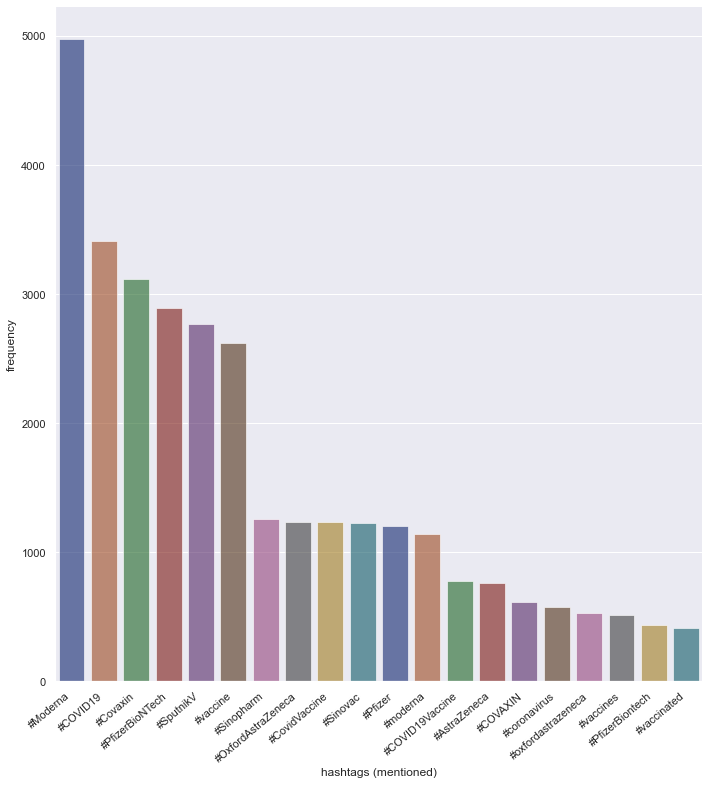

In [292]:
#f, ax = plt.subplots(figsize=(7, 5))

g = sns.catplot(
    data=frequency_hashtags, kind="bar",
    x="text_hasht_freq", y="count",# hue="sex",
    ci="sd", palette="dark", height=10, alpha=.6
)
#g.despine(left=True)
g.set_axis_labels("hashtags (mentioned)", "frequency")
g.set_xticklabels(rotation=40, ha="right")
#g.legend.set_title("")

### Most frequently mentioned twitter accounts

In [293]:
twitter_accounts = []
for line in df_tweety['text']:
    words = line.split()
    for word in words:
        if re.search('@[^\s]+', word):
            twitter_accounts.append(word)
mentioned_accounts=pd.Series(np.array(twitter_accounts))
accounts = mentioned_accounts.value_counts()[:20].rename_axis('accounts').reset_index(name='count')

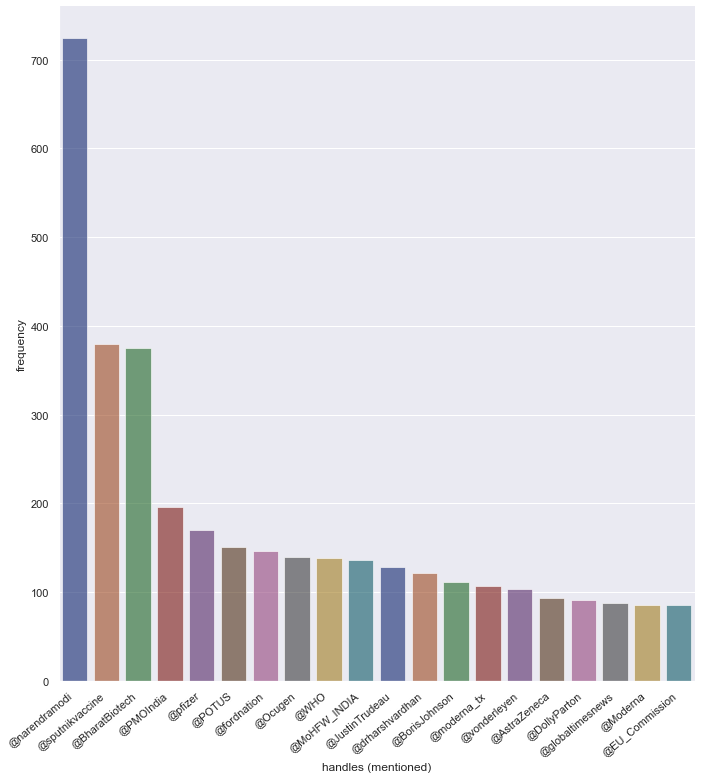

In [294]:
#f, ax = plt.subplots(figsize=(7, 5))

g = sns.catplot(
    data=accounts, kind="bar",
    x="accounts", y="count",# hue="sex",
    ci="sd", palette="dark", height=10, alpha=.6
)
#g.despine(left=True)
g.set_axis_labels("handles (mentioned)", "frequency")
g.set_xticklabels(rotation=40, ha="right")
#g.legend.set_title("")

We see that politicians, political institutions and vaccine producers are the most requently mentioned twitter accounts. This points towards vaccination being regarded as a political topic beyond a scientific one. Therefore, any em

### Most frequent hashtags in 'hashtags'

In [295]:
df_tweety['hashtags'].value_counts()

['Moderna']                                       1651
['Covaxin']                                       1510
['SputnikV']                                      1226
['PfizerBioNTech']                                 820
['OxfordAstraZeneca']                              557
                                                  ... 
['Pfizer', 'Moderna', 'covid19']                     1
['GetVaccinated', 'Hongkong']                        1
['Covaxin', 'mondaythoughts', 'CoronaVaccine']       1
['Moderna', 'PresidentBiden', 'VPHarris']            1
['covaxin', 'OCGN']                                  1
Name: hashtags, Length: 14360, dtype: int64

Lists in 'hashtags' are stored as strings

In [296]:
#for i, l in enumerate(df_tweety['hashtags']):
    #print("list",i,"is",type(l))

lst_ = "['erst', 'zweit', 'dritt']"

def clean_hashtag(name):
    name = name.replace("[", "")
    name = name.replace("]", "")
    name = name.replace("'", "")
    name_lst = name.split(",")
    hash_lst = list()
    for item in name_lst:
        item = item.strip()
        hash_lst.append(item)
    return hash_lst

In [299]:
df_tweety['hashtags'] = df_tweety['hashtags'].apply(eval)

In [300]:
df_tweety['hashtags'] = df_tweety['hashtags'].fillna('[]')

def to_1D(Series):
    return pd.Series([x.lower() for lst in Series for x in lst])

hasht_freq = to_1D(df_tweety['hashtags']).value_counts()[:30].rename_axis('hasht_freq').reset_index(name='count')
hasht_freq

,hasht_freq,count
0,moderna,7018
1,covaxin,4853
2,covid19,4685
3,pfizerbiontech,3852
4,vaccine,3597
5,sputnikv,3353
6,oxfordastrazeneca,1934
7,covidvaccine,1820
8,pfizer,1754
9,sinovac,1591


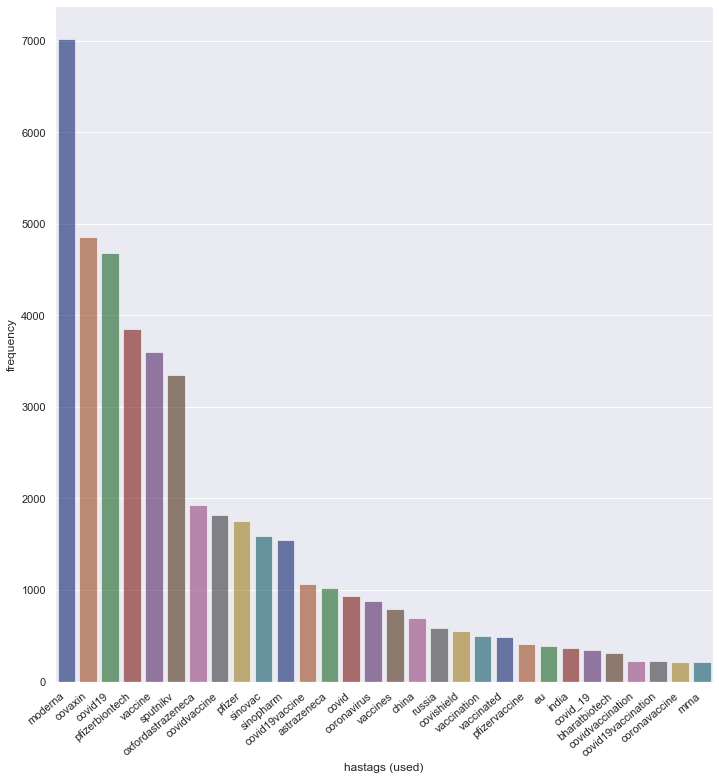

In [301]:
#f, ax = plt.subplots(figsize=(7, 5))

g = sns.catplot(
    data=hasht_freq, kind="bar",
    x="hasht_freq", y="count",# hue="sex",
    ci="sd", palette="dark", height=10, alpha=.6
)
#g.despine(left=True)
g.set_axis_labels("hastags (used)", "frequency")
g.set_xticklabels(rotation=40, ha="right")
#g.legend.set_title("")

In contrast, particular vaccines or the vaccination topic play the dominant role in the category of used hashtags. Politicians or institutions do not figure prominently in this category.

### Most mentioned countries in 'hashtags'
We can however spot that countries get mentioned in used hashtags. China, Russia, India and the EU trend at the top. This might be relevant to compare with vaccination progress in these countries.

In [302]:
df_tweety['hashtags'] = df_tweety['hashtags'].fillna('[]')

def to_1D(Series):
    return pd.Series([x.upper() for lst in Series for x in lst if x.lower() in ['china', 'eu', 'india', 'usa', 'scotland', 'england', 'russia', 'uk', 'italy', 'germany', 'france', 'america', 'brazil', 'japan', 'canada', 'afghanistan', 'china']])

to_1D(df_tweety['hashtags']).value_counts()[:30].rename_axis('hasht_country_freq').reset_index(name='count')

,hasht_country_freq,count
0,CHINA,699
1,RUSSIA,580
2,EU,392
3,INDIA,368
4,UK,109
5,CANADA,103
6,ITALY,101
7,USA,82
8,BRAZIL,70
9,GERMANY,65


### overtweeted (one tweet several times)

In [303]:
repeated_tweets = []
for i in range(len(df_tweety['text'])):
    repeated_tweets.append(df_tweety['text'][i])
repeated_tweets=pd.Series(np.array(repeated_tweets))
#list_of_words

frequency_ranking_tweets = repeated_tweets.value_counts()[:30].rename_axis('overtweeted').reset_index(name='count')
#frequency_ranking_tweets

## Rank #s, append hashtag columns to dataframe

Idea: create df with vaccines in hashtags as columns and append it to df_tweety

In [304]:
def to_1D(Series):
    return pd.Series([x.lower() for lst in Series for x in lst])

unique_hasht = to_1D(df_tweety['hashtags']).value_counts()[:30]

In [305]:
def boolean_df(item_lists, unique_items):

    # Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask that returns a True-False list of whether a tag is in a taglist
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [306]:
hasht_bool = boolean_df(df_tweety['hashtags'], unique_hasht.keys())
#Drop non-vaccine related columns
hasht_bool.drop(['covid19', 'covid', 'china', 'russia', 'bharatbiotech', 'eu', 'india', 'covid_19', 'coronavirus'], axis=1)

,moderna,covaxin,pfizerbiontech,vaccine,sputnikv,oxfordastrazeneca,covidvaccine,pfizer,sinovac,sinopharm,...,astrazeneca,vaccines,covishield,vaccination,vaccinated,pfizervaccine,covidvaccination,covid19vaccination,coronavaccine,mrna
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38515,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38516,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38517,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38518,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Rank mentioned @s, append columns to data frame

In [307]:
twitter_accounts = []
for tweet in df_tweety['text']:
    if '@' not in tweet:
        twitter_accounts.append('')
    words = tweet.split()
    for word in words:
        if re.search('@[^\s]+', word):
            twitter_accounts.append(word)
mentioned_accounts=pd.Series(np.array(twitter_accounts))
accounts = mentioned_accounts.value_counts().rename_axis('accounts').reset_index(name='count')
accounts

,accounts,count
0,,26744
1,@narendramodi,724
2,@sputnikvaccine,380
3,@BharatBiotech,375
4,@PMOIndia,196
...,...,...
8745,@Mukherjeemanas9,1
8746,@drsimonegold,1
8747,@kdjhaveri,1
8748,@fandomlover42,1


In [308]:
def to_1D(Series):
    return pd.Series([x for x in Series])

unique_handle = to_1D(mentioned_accounts).value_counts()[:30]
unique_handle

                    26744
@narendramodi         724
@sputnikvaccine       380
@BharatBiotech        375
@PMOIndia             196
@pfizer               170
@POTUS                151
@fordnation           146
@Ocugen               140
@WHO                  138
@MoHFW_INDIA          136
@JustinTrudeau        128
@drharshvardhan       122
@BorisJohnson         111
@moderna_tx           107
@vonderleyen          103
@AstraZeneca           93
@DollyParton           91
@globaltimesnews       88
@Moderna               86
@EU_Commission         85
@Swamy39               84
@EMA_News              83
@BioNTech              82
@NOVAVAX               81
@JoeBiden              71
@CPHO_Canada           70
@ANI                   65
@YouTube               63
@ICMRDELHI             63
dtype: int64

In [309]:
def handle_df(item_lists, unique_items):

    # Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask that returns a True-False list of whether a tag is in a taglist
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [310]:
handle_bool = handle_df(mentioned_accounts, unique_handle.keys())
handle_bool

,,@narendramodi,@sputnikvaccine,@BharatBiotech,@PMOIndia,@pfizer,@POTUS,@fordnation,@Ocugen,@WHO,...,@EU_Commission,@Swamy39,@EMA_News,@BioNTech,@NOVAVAX,@JoeBiden,@CPHO_Canada,@ANI,@YouTube,@ICMRDELHI
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46181,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
46182,True,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
46183,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
46184,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [311]:
df_tweety_vaccs = pd.concat([df_tweety, hasht_bool], axis=1)
df_tweety_vaccs = df_tweety_vaccs.drop(['user_followers', 'user_friends', 'user_favourites', 'hashtags', 'user_verified', 'date'], axis=1)

# Cleaning 'text' (round 1)

### Various removals, lowercase()

def CleanTweet(x):
    #remove twitter handlers
    x = re.sub('@[^\s]+','',x)
    #remove hashtags
    x = re.sub(r'\B#\S+','',x)
    #remove urls
    x = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x)
    #remove special characters
    x = re.findall(r'\w+', x)
    #remove single characters
    x = re.sub(r'\s+[a-zA-Z]\s+', '', x)
    #substitute multiple spaces with single space
    x = re.sub(r'\s+', ' ', x, flags=re.I)
    return x

In [312]:
#df_tweety.text = df_tweety.text.apply(CleanTweet)

In [313]:
#remove twitter handlers
df_tweety.text = df_tweety.text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\B#\S+','',x))

#remove URLs
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x))

#remove punctuation
#df_tweety.text = df_tweety.text.apply(lambda x:x.replace('[^\w\s]',''))

#remove special characters
#df_tweety.text = df_tweety.text.apply(lambda x:' '.join(re.findall(r'\w+', x))) #re.sub('[^A-Za-z0-9]+', '', x)

#remove single characters
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

#substitute multiple spaces with single space
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

#lowercase
#df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([word.lower() for word in x.split()]))

#remove numbers from words
df_tweety.text = df_tweety.text.apply(lambda x: re.sub('\w*\d\w*', '', x))

#remove linebreaks
df_tweety.text = df_tweety.text.apply(lambda x: re.sub('\n', '', x))

#remove characters
#df_tweety.text = df_tweety.text.apply(lambda x: re.sub('[''""_/]', '', x))

# Feature engineering 'text'

### stopwords, stemming, lemmatizing

In [227]:
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
df_tweety.text = df_tweety.text.apply(lambda x:' '.join([word for word in x.split() if word not in stopwords]))

In [228]:
#tokenize
#df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([word_tokenize(word) for word in x.split() ]))

In [229]:
# stemming 
stemmer = PorterStemmer()
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() ]))

In [230]:
# lemmazation
lemmatizer = WordNetLemmatizer()
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() ]))

Try to turn abbreviations into regular strings

In [231]:
import csv

#helper function to turn abbreviations into words and delete slang
def translator(user_string):
    user_string = user_string.split(" ")
    j = 0
    for _str in user_string:
        # File path which consists of Abbreviations.
        fileName = "/Users/JDSeo/Desktop/Daily-Neural-Network-Practice-2/NLP/cleaning/slang.txt"
        with open(fileName, "r") as myCSVfile:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            dataFromFile = csv.reader(myCSVfile, delimiter="=")
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9]+', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its appropriate phrase in text file.
                    user_string[j] = row[1]
            myCSVfile.close()
        j = j + 1
    return ' '.join(user_string)

# First sentiment analysis (VADER)

In [232]:
#!pip install vaderSentiment

In [233]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [234]:
analyser = SentimentIntensityAnalyzer()

scores=[]
for i in range(len(df_tweety['text'])):
    
    score = analyser.polarity_scores(df_tweety['text'][i])
    score=score['compound']
    scores.append(score)
    
sentiment=[]
for i in scores:
    if i>=0.05:
        sentiment.append('positive')
    elif i<=(-0.05):
        sentiment.append('negative')
    else:
        sentiment.append('neutral')

df_tweety['sentiment']=pd.Series(np.array(sentiment))
df_tweety_vaccs['sentiment']=pd.Series(np.array(sentiment))

In [235]:
df_tweety

,index,user_name,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,retweets,favorites,day,sentiment
0,0,Rachel Roh,"La Crescenta-Montrose, CA",405,1692,3247,False,2020-12-20 06:06:44,same folk said daikon past could treat cytokin...,[PfizerBioNTech],0,0,2020-12-20,positive
1,1,Albert Fong,"San Francisco, CA",834,666,178,False,2020-12-13 16:27:13,"while world wrong side histori year, hopefully...",[],1,1,2020-12-13,negative
2,2,eli🇱🇹🇪🇺👌,Your Bed,10,88,155,False,2020-12-12 20:33:45,russian vaccin creat last - years…,"[coronavirus, SputnikV, AstraZeneca, PfizerBio...",0,0,2020-12-12,neutral
3,3,Charles Adler,"Vancouver, BC - Canada",49165,3933,21853,True,2020-12-12 20:23:59,"fact immutable, senator, even ethic sturdi eno...",[],446,2129,2020-12-12,neutral
4,4,Citizen News Channel,NaN,152,580,1473,False,2020-12-12 20:17:19,explain need vaccin,"[whereareallthesickpeople, PfizerBioNTech]",0,0,2020-12-12,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38515,38542,Rising Bharat,Village,625,0,0,False,2021-03-18 06:22:41,the sputnikreview emerg use author india. It m...,[],1,7,2021-03-18,neutral
38516,38543,Bright Uzbekistan,Uzbekistan,18,182,59,False,2021-03-18 06:13:08,IT IS plan TO start mass vaccin IN uzbekistan ...,[],0,0,2021-03-18,neutral
38517,38544,Sputnik V,"Moscow, Russia",223700,142,678,True,2021-03-18 06:01:50,austrian chancellor sebastian kurz: concern va...,[SputnikV],83,226,2021-03-18,neutral
38518,38545,Sputnik,NaN,322326,306,24,True,2021-03-18 05:30:00,norwegian politician call cut vaccin deal amid...,[SputnikV],6,16,2021-03-18,negative


In [264]:
df_tweety.sentiment.value_counts()/len(df_tweety)

neutral     0.547508
positive    0.304621
negative    0.147871
Name: sentiment, dtype: float64

## Sentiment Plotting

### General

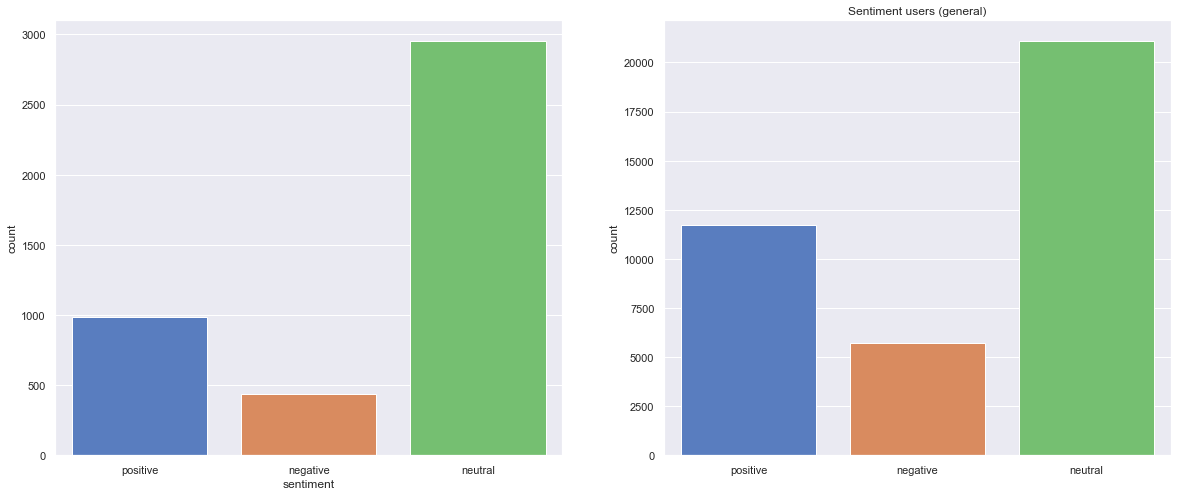

In [236]:
order_list = ['positive', 'negative', 'neutral']
plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
sns.countplot(x='sentiment',data=df_tweety[df_tweety['user_verified']==True], order = order_list)
ax.set(xlabel='', ylabel='count', title='Sentiment users (verified)')
plt.subplot(1, 2, 2)

order_list = ['positive', 'negative', 'neutral']
ax = sns.countplot(x='sentiment',data=df_tweety, order = order_list)
ax.set(xlabel='', ylabel='count', title='Sentiment users (general)')
plt.show()

### Vaccines

In [237]:
#Create subframes for plotting based on hashtag-bools
df_moderna = df_tweety_vaccs[(df_tweety_vaccs['moderna']==True)]
df_moderna = df_moderna[['moderna', 'sentiment']]

df_vacc = df_tweety_vaccs[(df_tweety_vaccs['vaccine']==True) | 
                          (df_tweety_vaccs['vaccinated']==True) |
                          (df_tweety_vaccs['vaccines']==True) |
                          (df_tweety_vaccs['covidvaccination']==True)|
                          (df_tweety_vaccs['coronavaccine']==True)|
                          (df_tweety_vaccs['covid19vaccination']==True)]
#df_vacc = df_vacc['sentiment']

df_sinovac = df_tweety_vaccs[(df_tweety_vaccs['sinovac']==True)]
df_sinovac = df_sinovac[['sinovac', 'sentiment']]

df_sinopharm = df_tweety_vaccs[(df_tweety_vaccs['sinopharm']==True)]
df_sinopharm = df_sinopharm[['sinopharm', 'sentiment']]

df_biontech = df_tweety_vaccs[(df_tweety_vaccs['pfizerbiontech']==True)|
                              (df_tweety_vaccs['pfizer']==True)|
                              (df_tweety_vaccs['pfizervaccine']==True)]
df_biontech = df_biontech[['sentiment']]

df_astrazeneca = df_tweety_vaccs[(df_tweety_vaccs['astrazeneca']==True)|
                                (df_tweety_vaccs['oxfordastrazeneca']==True)|
                                (df_tweety_vaccs['moderna']==True)]

df_astrazeneca = df_astrazeneca[['sentiment']]

df_sputnik = df_tweety_vaccs[(df_tweety_vaccs['sputnikv']==True)]
df_sputnik = df_sputnik[['sputnikv', 'sentiment']]

df_mrna = df_tweety_vaccs[(df_tweety_vaccs['mrna']==True)]
df_mrna = df_mrna[['mrna', 'sentiment']]

[Text(0.5, 0, ''), Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Sputnik V')]

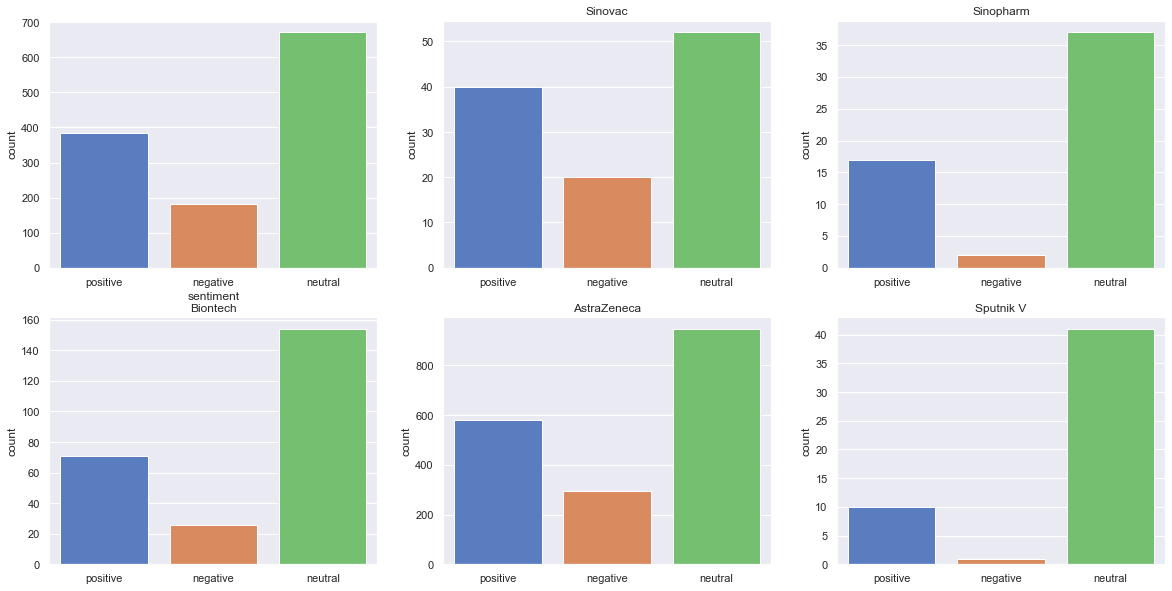

In [238]:
order_list = ['positive', 'negative', 'neutral']

plt.figure(figsize = (20, 10))

plt.subplot(2, 3, 1)
sns.countplot(x='sentiment',data=df_moderna, order = order_list)
ax.set(xlabel='', ylabel='count', title='Moderna')
plt.subplot(2, 3, 2)
ax = sns.countplot(x='sentiment',data=df_sinovac, order = order_list)
ax.set(xlabel='', ylabel='count', title='Sinovac')

plt.subplot(2, 3, 3)
ax = sns.countplot(x='sentiment',data=df_sinopharm, order = order_list)
ax.set(xlabel='', ylabel='count', title='Sinopharm')
plt.subplot(2, 3, 4)
ax = sns.countplot(x='sentiment',data=df_biontech, order = order_list)
ax.set(xlabel='', ylabel='count', title='Biontech')
plt.subplot(2, 3, 5)
ax = sns.countplot(x='sentiment',data=df_astrazeneca, order = order_list)
ax.set(xlabel='', ylabel='count', title='AstraZeneca')

plt.subplot(2, 3, 6)
ax = sns.countplot(x='sentiment',data=df_sputnik, order = order_list)
ax.set(xlabel='', ylabel='count', title='Sputnik V')


[Text(0.5, 0, ''), Text(0, 0.5, 'count'), Text(0.5, 1.0, 'mrna')]

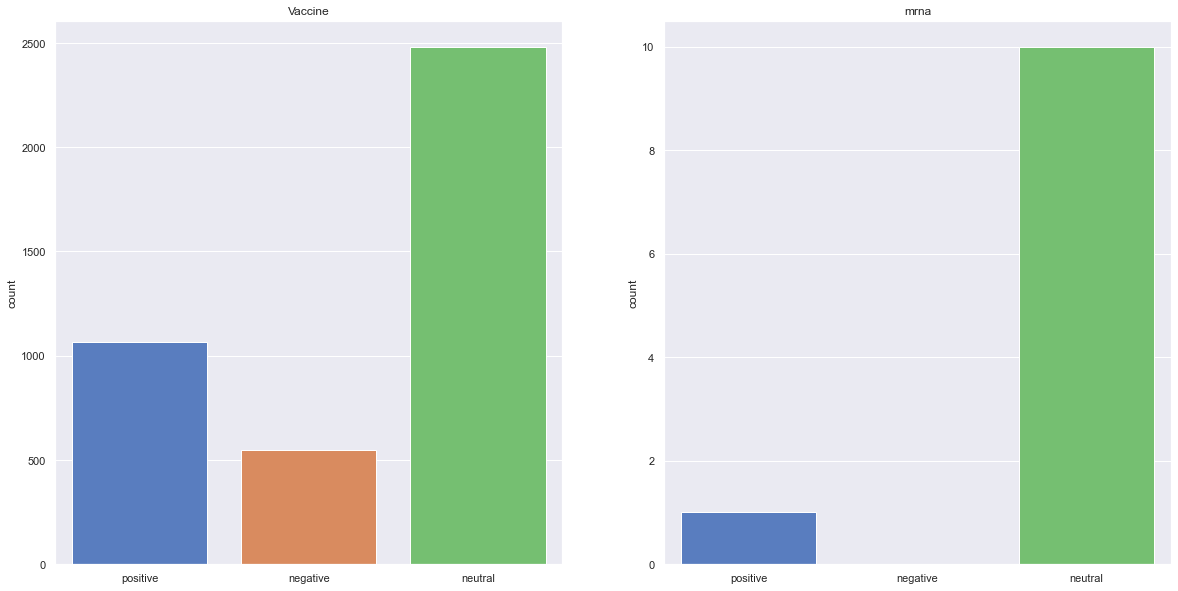

In [239]:
order_list = ['positive', 'negative', 'neutral']

plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
ax = sns.countplot(x='sentiment',data=df_vacc, order = order_list)
ax.set(xlabel='', ylabel='count', title='Vaccine')

plt.subplot(1, 2, 2)
ax = sns.countplot(x='sentiment',data=df_mrna, order = order_list)
ax.set(xlabel='', ylabel='count', title='mrna')


## Influential

Identify whether the most popular users tweet predominantly positively, negatively or neutrally. Is it possible to see, how their followers tweet? Is there a mutual influence?

Create a measure of influence

In [240]:
twinfluence1 = df_tweety.sort_values("user_followers", ascending=False)

### by 'user_follower'

<AxesSubplot:xlabel='user_followers', ylabel='user_name'>

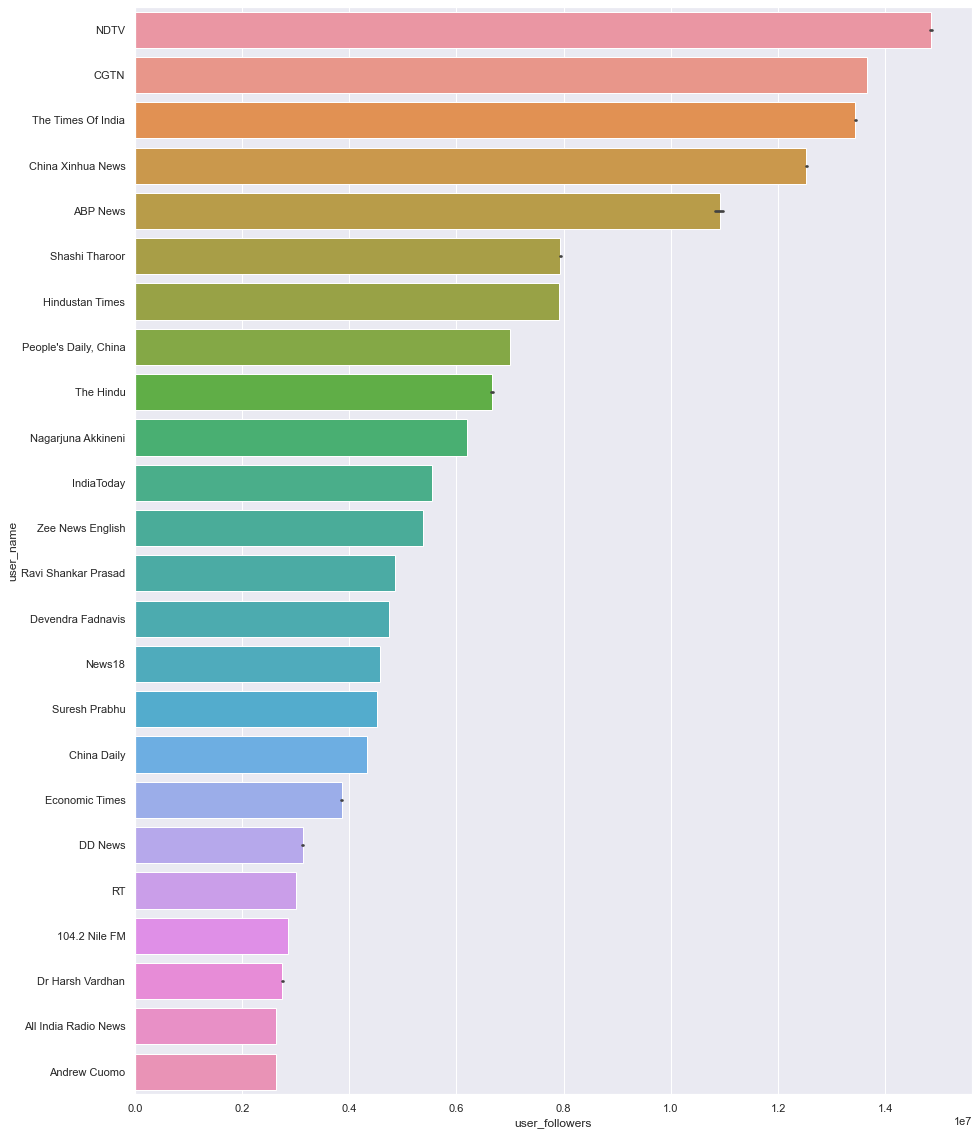

In [241]:
f, ax = plt.subplots(figsize=(15, 20))
sns.barplot(x='user_followers', y='user_name', orient='h', data=twinfluence1[['user_name', 'user_followers']][:400])

<AxesSubplot:xlabel='user_followers', ylabel='user_name'>

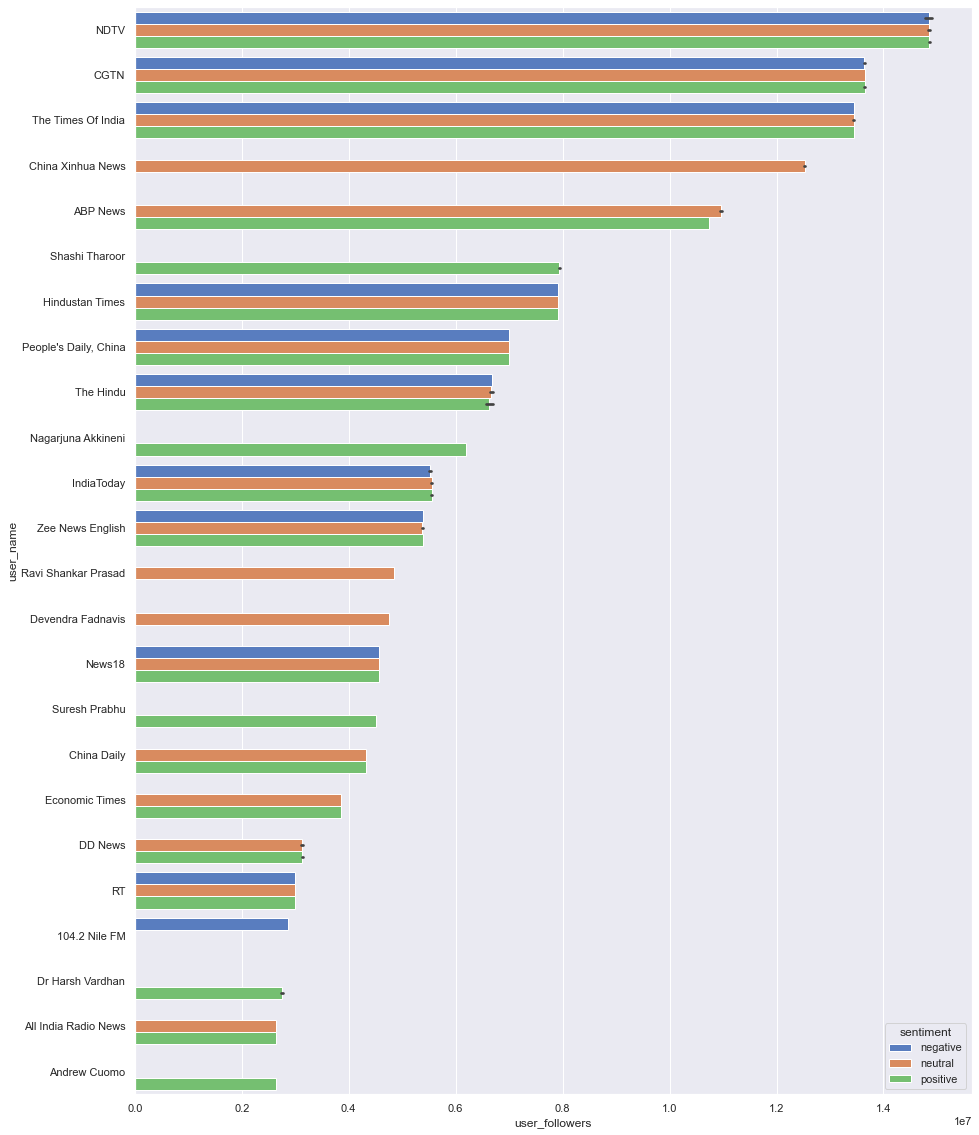

In [242]:
order_list = ['positive', 'negative', 'neutral']
f, ax = plt.subplots(figsize=(15, 20))
sns.barplot(x='user_followers', y='user_name', hue='sentiment', orient='h', data=twinfluence1[['user_name', 'user_followers', 'sentiment']][:400])

In [243]:
# delete multiples for certain purposes! Written

### retweeted

<AxesSubplot:xlabel='retweets', ylabel='user_name'>

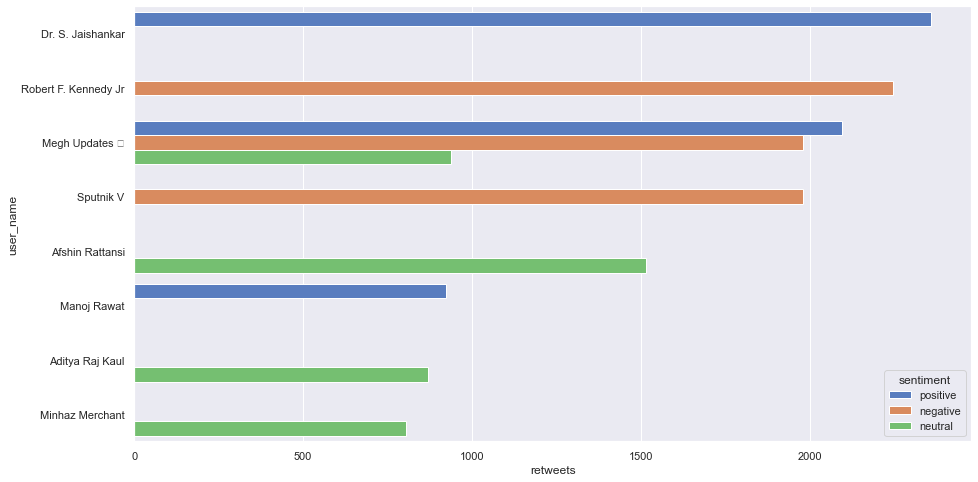

In [244]:
twinfluence2 = df_tweety.sort_values("retweets", ascending=False)

f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='retweets', y='user_name', orient='h', hue='sentiment', data=twinfluence2[['retweets', 'user_name', 'sentiment']][:10])

### 'user_favourites'

<AxesSubplot:xlabel='user_favourites', ylabel='user_name'>

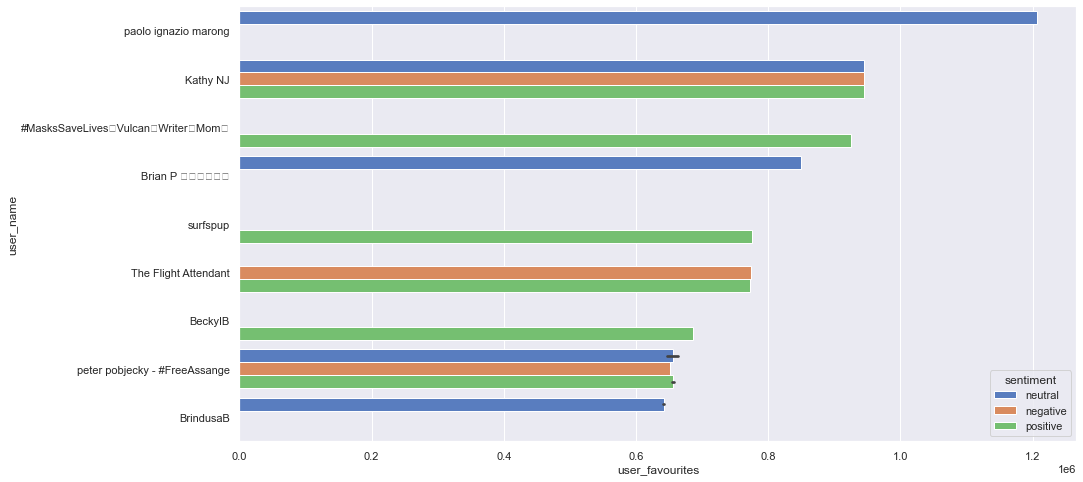

In [245]:
twinfluence3 = df_tweety.sort_values("user_favourites", ascending=False)

f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='user_favourites', y='user_name',  hue='sentiment', orient='h', data=twinfluence3[['user_name', 'user_favourites', 'sentiment']][:20])

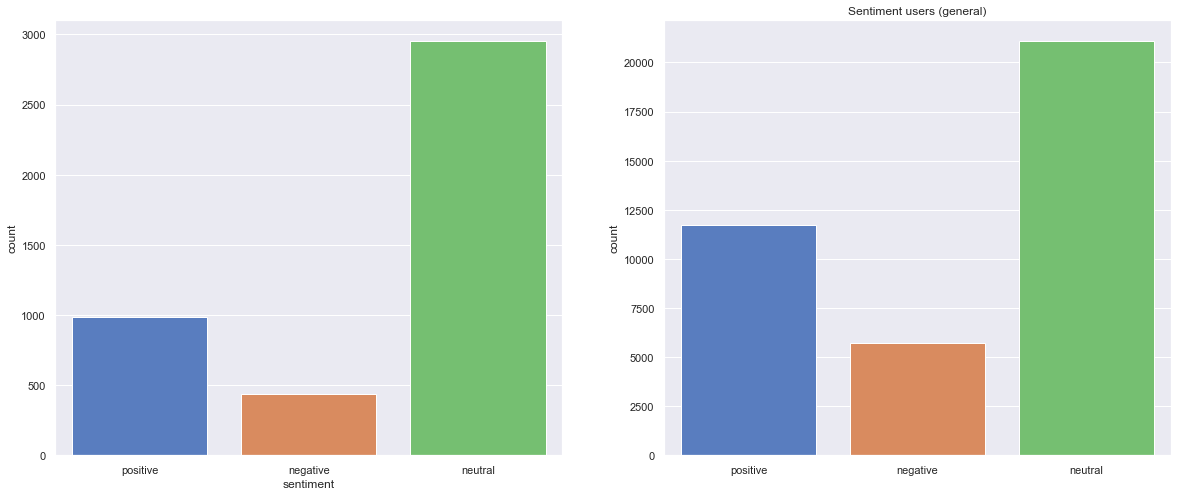

In [246]:
order_list = ['positive', 'negative', 'neutral']
plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
sns.countplot(x='sentiment',data=df_tweety[df_tweety['user_verified']==True], order = order_list)
ax.set(xlabel='', ylabel='count', title='Sentiment users (verified)')
plt.subplot(1, 2, 2)
ax = sns.countplot(x='sentiment',data=df_tweety, order = order_list)
ax.set(xlabel='', ylabel='count', title='Sentiment users (general)')
plt.show()

In [247]:
#df_tweety = pd.concat([df_tweety, pd.get_dummies(df_tweety['sentiment'], drop_first=False)], axis=1)

### Number of tweets over time

In [248]:
over_days = df_tweety.groupby(['day'])['index'].count().reset_index()
over_days.columns = ['day', 'count']

<AxesSubplot:xlabel='day', ylabel='count'>

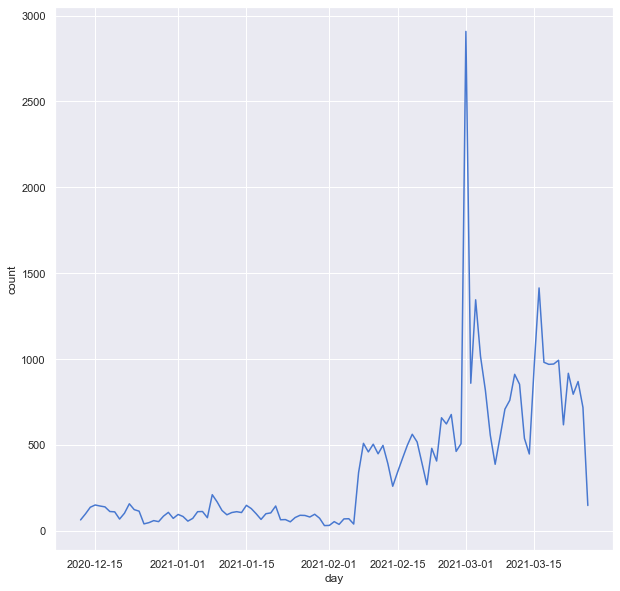

In [249]:

f, ax = plt.subplots(1,1, figsize=(10, 10))
sns.lineplot(x="day", y="count",
             data=over_days)

What happened on the first of march, in mid-february and in mid-march?

### Sentiments over time

In [251]:
tweety_wide = pd.pivot_table(df_tweety, index='day', columns='sentiment', values='index', aggfunc=pd.Series.nunique)

<AxesSubplot:xlabel='day'>

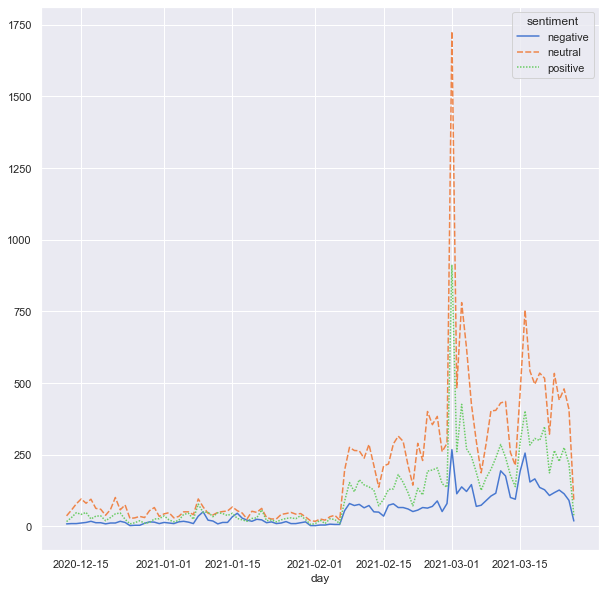

In [252]:
f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=tweety_wide)

### Unanimous sentiment values VADER, BLOB

In [253]:
blob_sent = pd.read_csv('blob_sent.csv')

In [254]:
blob_sent

,Unnamed: 0,sentiment
0,0,negative
1,1,negative
2,2,neutral
3,3,neutral
4,4,neutral
...,...,...
38542,38542,neutral
38543,38543,neutral
38544,38544,neutral
38545,38545,positive


In [255]:
df_tweety['blob_sent'] = blob_sent['sentiment']

In [257]:
df_tweety

,index,user_name,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,retweets,favorites,day,sentiment,blob_sent
0,0,Rachel Roh,"La Crescenta-Montrose, CA",405,1692,3247,False,2020-12-20 06:06:44,same folk said daikon past could treat cytokin...,[PfizerBioNTech],0,0,2020-12-20,positive,negative
1,1,Albert Fong,"San Francisco, CA",834,666,178,False,2020-12-13 16:27:13,"while world wrong side histori year, hopefully...",[],1,1,2020-12-13,negative,negative
2,2,eli🇱🇹🇪🇺👌,Your Bed,10,88,155,False,2020-12-12 20:33:45,russian vaccin creat last - years…,"[coronavirus, SputnikV, AstraZeneca, PfizerBio...",0,0,2020-12-12,neutral,neutral
3,3,Charles Adler,"Vancouver, BC - Canada",49165,3933,21853,True,2020-12-12 20:23:59,"fact immutable, senator, even ethic sturdi eno...",[],446,2129,2020-12-12,neutral,neutral
4,4,Citizen News Channel,NaN,152,580,1473,False,2020-12-12 20:17:19,explain need vaccin,"[whereareallthesickpeople, PfizerBioNTech]",0,0,2020-12-12,neutral,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38515,38542,Rising Bharat,Village,625,0,0,False,2021-03-18 06:22:41,the sputnikreview emerg use author india. It m...,[],1,7,2021-03-18,neutral,positive
38516,38543,Bright Uzbekistan,Uzbekistan,18,182,59,False,2021-03-18 06:13:08,IT IS plan TO start mass vaccin IN uzbekistan ...,[],0,0,2021-03-18,neutral,neutral
38517,38544,Sputnik V,"Moscow, Russia",223700,142,678,True,2021-03-18 06:01:50,austrian chancellor sebastian kurz: concern va...,[SputnikV],83,226,2021-03-18,neutral,neutral
38518,38545,Sputnik,NaN,322326,306,24,True,2021-03-18 05:30:00,norwegian politician call cut vaccin deal amid...,[SputnikV],6,16,2021-03-18,negative,neutral


In [258]:
df_unanim = df_tweety[df_tweety['sentiment']==df_tweety['blob_sent']]

In [259]:
df_unanim.shape

(17768, 15)

In [262]:
df_unanim.drop(['blob_sent'], axis=1).reset_index(drop=True)

,index,user_name,user_location,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,retweets,favorites,day,sentiment
0,1,Albert Fong,"San Francisco, CA",834,666,178,False,2020-12-13 16:27:13,"while world wrong side histori year, hopefully...",[],1,1,2020-12-13,negative
1,2,eli🇱🇹🇪🇺👌,Your Bed,10,88,155,False,2020-12-12 20:33:45,russian vaccin creat last - years…,"[coronavirus, SputnikV, AstraZeneca, PfizerBio...",0,0,2020-12-12,neutral
2,3,Charles Adler,"Vancouver, BC - Canada",49165,3933,21853,True,2020-12-12 20:23:59,"fact immutable, senator, even ethic sturdi eno...",[],446,2129,2020-12-12,neutral
3,4,Citizen News Channel,NaN,152,580,1473,False,2020-12-12 20:17:19,explain need vaccin,"[whereareallthesickpeople, PfizerBioNTech]",0,0,2020-12-12,neutral
4,5,Dee,"Birmingham, England",105,108,106,False,2020-12-12 20:11:42,doe anyon use advice/guid whether covid vaccin...,[],0,0,2020-12-12,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17763,38540,Raj Meister,"Leeds, England",1354,247,2931,False,2021-03-18 06:37:29,here’ killer manufactur &amp;,"[BrainTwister, Putin, MotherRussia, SputnikV, ...",0,0,2021-03-18,negative
17764,38541,Stankevicius International,"Dublin, Ireland",16,3,0,False,2021-03-18 06:29:12,selling: contact sales: o…,"[NitrileGloves, FaceMasks, Vaccines, SputnikV,...",0,0,2021-03-18,neutral
17765,38543,Bright Uzbekistan,Uzbekistan,18,182,59,False,2021-03-18 06:13:08,IT IS plan TO start mass vaccin IN uzbekistan ...,[],0,0,2021-03-18,neutral
17766,38544,Sputnik V,"Moscow, Russia",223700,142,678,True,2021-03-18 06:01:50,austrian chancellor sebastian kurz: concern va...,[SputnikV],83,226,2021-03-18,neutral
